In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["savefig.dpi"] = 240

In [2]:
sm15k = pd.read_parquet("data/sm15k.parquet", columns=["time", "voltage", "current"]).set_index("time")
cycles = pd.read_parquet("data/cycles.parquet")
un38_3 = pd.read_csv("../UN38.3/cycles.csv", index_col="cycle")

sm15k.head()

,voltage,current
time,,
2024-10-25 16:31:04.400000+00:00,23.6164,0.0164
2024-10-25 16:31:04.500000+00:00,23.6164,-0.0164
2024-10-25 16:31:04.600000+00:00,23.6164,0.0327
2024-10-25 16:31:04.700000+00:00,23.6164,-0.0491
2024-10-25 16:31:04.800000+00:00,23.6164,0.0327


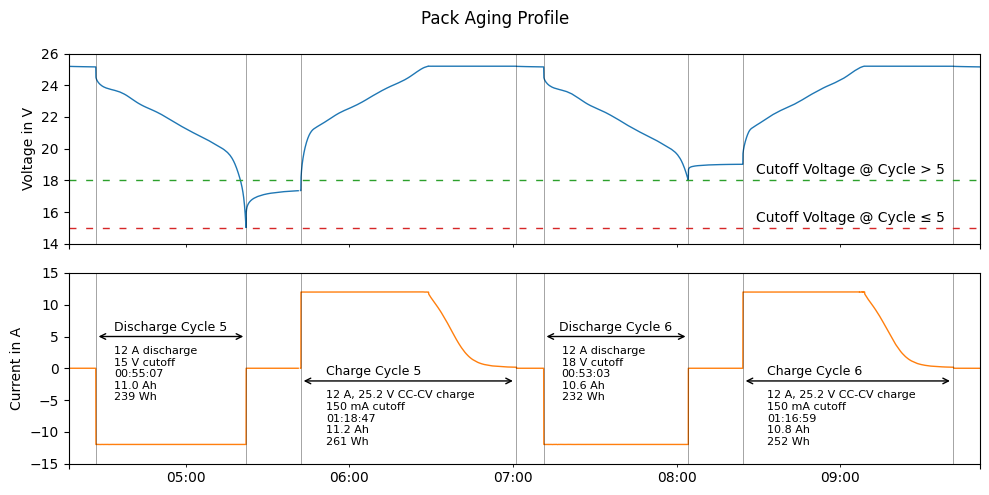

In [3]:
from matplotlib.patches import FancyArrowPatch

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

start = cycles.loc[5, "dsg_start"] - timedelta(minutes=10)
end = cycles.loc[6, "chg_end"] + timedelta(minutes=10)

sm15k.loc[start:end, "voltage"].resample("1s").mean().plot(ax=ax1, lw=1, c="C0", ylim=(14, 26))
sm15k.loc[start:end, "current"].resample("1s").mean().div(6).plot(ax=ax2, lw=1, c="C1", ylim=(-15, 15))

# Mark discharge and charge phases
for cycle, row in cycles.loc[5:6].iterrows():
    for ax in [ax1, ax2]:
        ax.axvline(row["dsg_start"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["dsg_end"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["chg_start"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["chg_end"], c="k", alpha=0.5, lw=0.5)

    arrow = FancyArrowPatch(
        (row["dsg_start"], 5),
        (row["dsg_end"], 5),
        arrowstyle="<->",
        mutation_scale=10,
    )
    ax2.add_patch(arrow)
    ax2.annotate(
        f"Discharge Cycle {cycle}",
        xy=(0.5, 1),
        xycoords=arrow,
        ha="center",
        va="bottom",
        fontsize=9,
    )
    cutoff = 15 if cycle <= 5 else 18
    dur = row["dsg_duration"].components
    ax2.annotate(
        f"12 A discharge\n"
        f"{cutoff} V cutoff\n"
        f"{dur.hours:02d}:{dur.minutes:02d}:{dur.seconds:02d}\n"
        f"{abs(row['dsg_charge_Ah'])/6:.1f} Ah\n"
        f"{abs(row['dsg_energy_Wh'])/6:.0f} Wh",
        xy=(0.1, -1.2),
        xycoords=arrow,
        ha="left",
        va="top",
        fontsize=8,
    )

    arrow = FancyArrowPatch(
        (row["chg_start"], -2),
        (row["chg_end"], -2),
        arrowstyle="<->",
        mutation_scale=10,
    )
    ax2.add_patch(arrow)
    ax2.annotate(
        f"Charge Cycle {cycle}",
        xy=(0.1, 1),
        xycoords=arrow,
        ha="left",
        va="bottom",
        fontsize=9,
    )
    dur = row["chg_duration"].components
    ax2.annotate(
        f"12 A, 25.2 V CC-CV charge\n"
        f"150 mA cutoff\n"
        f"{dur.hours:02d}:{dur.minutes:02d}:{dur.seconds:02d}\n"
        f"{abs(row['chg_charge_Ah'])/6:.1f} Ah\n"
        f"{abs(row['chg_energy_Wh'])/6:.0f} Wh",
        xy=(0.1, -1.2),
        xycoords=arrow,
        ha="left",
        va="top",
        fontsize=8,
    )

ax1.axhline(15, c="C3", ls=(0, (5, 7)), lw=1)
ax1.axhline(18, c="C2", ls=(0, (5, 7)), lw=1)

ax1.text(cycles.loc[6, "chg_end"] - timedelta(minutes=3), 15.2, "Cutoff Voltage @ Cycle ≤ 5", ha="right", va="bottom")
ax1.text(cycles.loc[6, "chg_end"] - timedelta(minutes=3), 18.2, "Cutoff Voltage @ Cycle > 5", ha="right", va="bottom")

ax1.set_ylabel("Voltage in V")
ax2.set_ylabel("Current in A")
ax2.set_xlabel(None)

fig.suptitle("Pack Aging Profile")
fig.tight_layout()
fig.savefig("img/aging-profile.png", dpi=240)

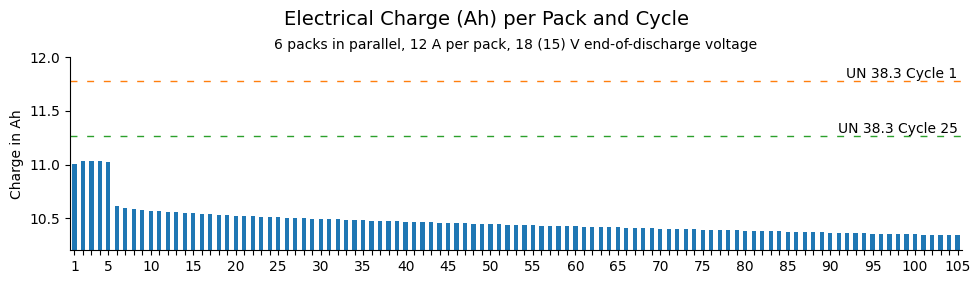

In [4]:
ax = cycles["dsg_charge_Ah"].mul(-1).div(6).plot.bar(figsize=(10, 3), ylim=(10.2, 12), ylabel="Charge in Ah")
plt.suptitle("Electrical Charge (Ah) per Pack and Cycle", y=0.93, fontsize=14)
ax.set_title("6 packs in parallel, 12 A per pack, 18 (15) V end-of-discharge voltage", fontsize=10)

q01 = -un38_3.loc[1, "dsg_charge_Ah"] / 4
q25 = -un38_3.loc[25, "dsg_charge_Ah"] / 4
ax.axhline(q01, c="C1", ls=(0, (5, 7)), lw=1)
ax.axhline(q25, c="C2", ls=(0, (5, 7)), lw=1)
ax.text(len(cycles) - 1, q01, "UN 38.3 Cycle 1", ha="right", va="bottom")
ax.text(len(cycles) - 1, q25, "UN 38.3 Cycle 25", ha="right", va="bottom")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

# Show only every 5th x-tick label
for idx, label in enumerate(ax.get_xticklabels(), start=1):
    if idx != 1 and idx % 5 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.savefig("img/charge-per-cycle.png")


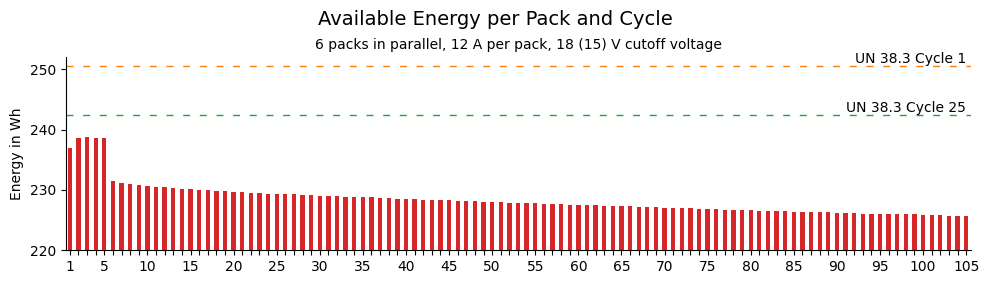

In [5]:
ax = cycles["dsg_energy_Wh"].div(-6).plot.bar(figsize=(10, 3), ylim=(220, 252), ylabel="Energy in Wh", color="C3")
plt.suptitle("Available Energy per Pack and Cycle", y=0.93, fontsize=14)
ax.set_title("6 packs in parallel, 12 A per pack, 18 (15) V cutoff voltage", fontsize=10)

e01 = -un38_3.loc[1, "dsg_energy_Wh"] / 4
e25 = -un38_3.loc[25, "dsg_energy_Wh"] / 4
ax.axhline(e01, c="C1", ls=(0, (5, 7)), lw=1)
ax.axhline(e25, c="C2", ls=(0, (5, 7)), lw=1)
ax.text(len(cycles) - 1, e01, "UN 38.3 Cycle 1", ha="right", va="bottom")
ax.text(len(cycles) - 1, e25, "UN 38.3 Cycle 25", ha="right", va="bottom")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

# Show only every 5th x-tick label
for idx, label in enumerate(ax.get_xticklabels(), start=1):
    if idx != 1 and idx % 5 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.savefig("img/energy-per-cycle.png")


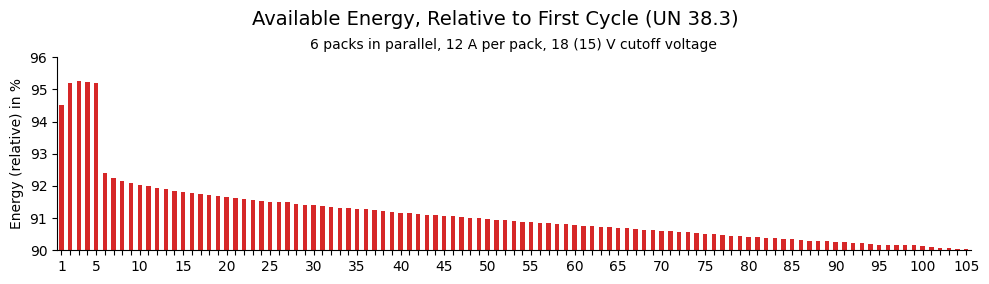

In [6]:
ax = (
    cycles["dsg_energy_Wh"]
    .div(6)
    .div(un38_3.loc[1, "dsg_energy_Wh"] / 4)
    .mul(100)
    .plot.bar(figsize=(10, 3), ylim=(90, 96), ylabel="Energy (relative) in %", color="C3")
)
plt.suptitle("Available Energy, Relative to First Cycle (UN 38.3)", y=0.93, fontsize=14)
ax.set_title("6 packs in parallel, 12 A per pack, 18 (15) V cutoff voltage", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

# Show only every 5th x-tick label
for idx, label in enumerate(ax.get_xticklabels(), start=1):
    if idx != 1 and idx % 5 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.savefig("img/relative-energy-per-cycle.png")
